# Import Python dependency package

In [1]:
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt

You need to install gurobi solver.

In [2]:
def display_points(points: np.ndarray) -> None:
    """
    Display a set of 2D points on a scatterplot.

    Args:

    Returns:
        object:
    points: x,y coordinate points.
    """

    y_offset = 0.025
    plt.scatter(points[:, 0], points[:, 1])
    for i, point in enumerate(points):
        plt.text(point[0], point[1] + y_offset, str(i))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(0., 1.)
        plt.ylim(0., 1.)
        # plt.title(f'N: {len(points)}')
        plt.grid(False)

## Random genearte scatter graph

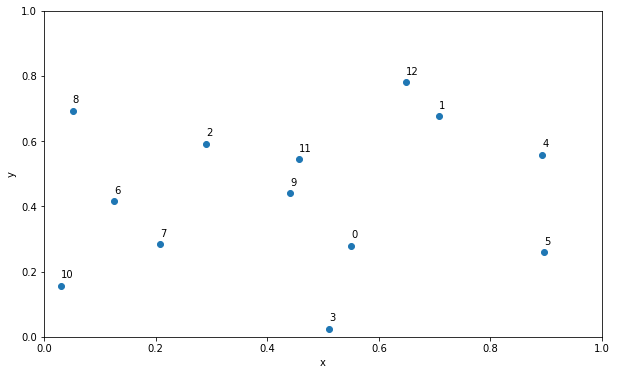

In [3]:
rng = np.random.RandomState(3)
n_points = 13
n_salesmen = 3
c_x = rng.rand(n_points)
c_y = rng.rand(n_points)
points =np.vstack((c_x, c_y)).T
plt.rcParams['figure.figsize'] = (10,6)
display_points(points)

In [4]:
def sovle_MTSP(c_x, c_y, n, m):
    N = len(c_x)
    f_x = c_x
    f_y = c_y
    d = np.sqrt(
        (c_x.reshape((-1, 1)) - f_x.reshape((1, -1))) ** 2 \
        + (c_y.reshape((-1, 1)) - f_y.reshape((1, -1))) ** 2)
    model = Model('MTSP')
    model.setParam('OutputFlag', False)
    # Add variables
    x = {}
    u={}
    for i in range(N):
        for j in range(N):
            x[i, j] = model.addVar(vtype="B", name="x(%s, %s)"%(i,j))
    for i in range(N):
        u[i] =model.addVar(name='u(%s)'%(i))
    model.update()

    model.addConstr(quicksum(x[0, j] for j in range(1, N)) == m)
    model.addConstr(quicksum(x[j, 0] for j in range(1, N)) == m)
    for j in range(1, N):
        model.addConstr(quicksum(x[i, j] for i in range(N)) == 1)
    for i in range(1, N):
        model.addConstr(quicksum(x[i, j] for j in range(N)) == 1)
        model.addConstr(x[0, i] + x[i, 0]<=1)
    for i in range(1, N):
        for j in range(1, N):
            if i != j:
                model.addConstr(u[i]-u[j]+(n-m)*x[i, j]<=n-m-1)
    for i in range(N):
        model.addConstr(x[i, i] == 0)
    model.setObjective(quicksum(d[(i, j)] * x[i, j] for i in range(N) for j in range(N)))

    model.optimize()
    sol = model.objVal
    x_result = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x_result[i, j] = x[i, j].X

    return x_result, sol

def display_points_with_MTSP(points, X):
    N = len(X)
    display_points(points)
    cs = [ "orange", "green", 'steelblue']
    i = 0
    t = 0
    s = []
    for j in range(N):
        if X[i, j] == 1:
            s.append(j)
            p1 = points[i]
            p2 = points[j]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=cs[t])
            t = t + 1
    t = -1
    for k in s:
        j = k
        t = t + 1
        while j != 0:
            i = j
            j = np.where(X[i,:]==1)[0][0]
            p1 = points[i]
            p2 = points[j]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=cs[t])

    plt.grid(False)

We use the gurobi solver solving the Standard-MTSP and display the solution.

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-13


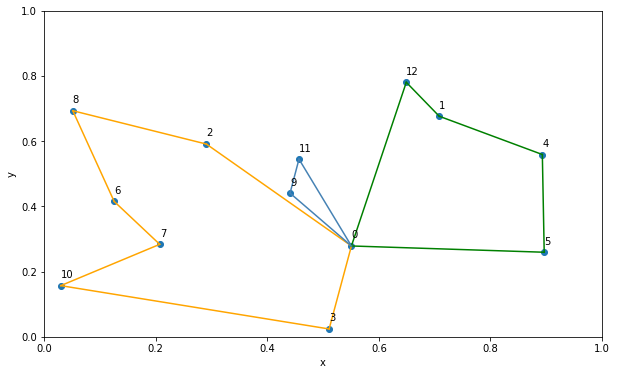

In [5]:
X, X_sol = sovle_MTSP(c_x, c_y, n_points, n_salesmen)
plt.rcParams['figure.figsize'] = (10,6)
display_points_with_MTSP(points, X)

In [6]:
def sovle_Minmax_MTSP(c_x, c_y, N, m):
    f_x = c_x
    f_y = c_y
    d = np.sqrt(
        (c_x.reshape((-1, 1)) - f_x.reshape((1, -1))) ** 2 \
        + (c_y.reshape((-1, 1)) - f_y.reshape((1, -1))) ** 2)
    model = Model('MinMax_MTSP')
    model.setParam('OutputFlag', False)
    # Add variables
    x = {}
    u={}
    Q = model.addVar(name="Q")
    for i in range(N):
        for j in range(N):
            for k in range(m):
                x[i, j, k] = model.addVar(vtype="B", name="x(%s, %s, %s)"%(i,j,k))
    for i in range(N):
        u[i] =model.addVar(name='u(%s)'%(i))

    model.update()
    # model.setObjective(quicksum(d[(i, j)] * x[i, j] for i in range(N) for j in range(N)))
    for k in range(m):
        model.addConstr(quicksum(x[0, j, k] for j in range(1, N)) == 1)
        model.addConstr(quicksum(x[j, 0, k] for j in range(1, N)) == 1)
    for j in range(1, N):
        model.addConstr(quicksum(x[i, j, k] for i in range(N) for k in range(m)) == 1)
    for i in range(1, N):
        model.addConstr(quicksum(x[i, j, k] for j in range(N) for k in range(m)) == 1)
    for j in range(1, N):
        for k in range(m):
            model.addConstr(quicksum(x[i, j, k] for i in range(N))==quicksum(x[j, i, k] for i in range(N)))
    for i in range(1, N):
        for j in range(1, N):
            if i != j:
                model.addConstr(u[i]-u[j]+(N-m)*quicksum(x[i, j, k] for k in range(m))<=N-m-1)
    for k in range(m):
        model.addConstr(quicksum(d[i, j]*x[i, j, k] for i in range(N) for j in range(N))<=Q)
    for i in range(N):
        for k in range(m):
            model.addConstr(x[i, i, k] == 0)

    model.setObjective(Q)

    model.optimize()

    x_result = np.zeros((N, N, m))
    total_dis = []
    for i in range(N):
        for j in range(N):
            for k in range(m):
                x_result[i, j, k] = x[i, j, k].X
                if x[i, j, k].X == 1:
                    total_dis.append(d[i,j])
    sol = model.objVal
    total_distance = sum(total_dis)
    return x_result, sol, total_distance

def display_points_with_Minmax_MTSP(points, X):
    N = X.shape[0]
    m = X.shape[2]
    display_points(points)
    cs = ["green", 'steelblue', "orange"]
    for i in range(N):
        for j in range(N):
            for k in range(m):
                if X[i, j, k] == 1:
                    # print(i, j, points[i], points[j])
                    p1 = points[i]
                    p2 = points[j]
                    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=cs[k])
                    # plt.scatter(points[i], points[j], color='b')
    plt.grid(False)

We use the gurobi solver solving the Minmax-MTSP and display the solution.

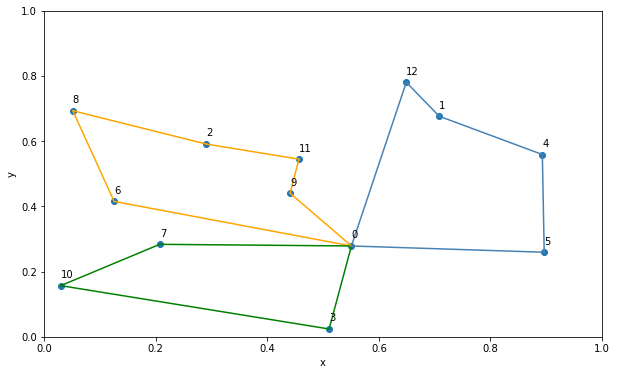

In [7]:
Y, Y_sol, total_distance = sovle_Minmax_MTSP(c_x, c_y, n_points, n_salesmen)
plt.rcParams['figure.figsize'] = (10,6)
display_points_with_Minmax_MTSP(points, Y)

In [8]:
def sovle_Bounded_MTSP(c_x, c_y, n, m, L, K):
    N = len(c_x)
    f_x = c_x
    f_y = c_y
    d = np.sqrt(
        (c_x.reshape((-1, 1)) - f_x.reshape((1, -1))) ** 2 \
        + (c_y.reshape((-1, 1)) - f_y.reshape((1, -1))) ** 2)
    model = Model('Bounded_MTSP')
    model.setParam('OutputFlag', False)
    # Add variables
    x = {}
    u={}
    for i in range(N):
        for j in range(N):
            x[i, j] = model.addVar(vtype="B", name="x(%s, %s)"%(i,j))
    for i in range(N):
        u[i] = model.addVar(name='u(%s)'%(i))
    model.update()

    model.addConstr(quicksum(x[0, j] for j in range(1, N)) == m)
    model.addConstr(quicksum(x[j, 0] for j in range(1, N)) == m)
    for j in range(1, N):
        model.addConstr(quicksum(x[i, j] for i in range(N)) == 1)
    for i in range(1, N):
        model.addConstr(quicksum(x[i, j] for j in range(N)) == 1)
        model.addConstr(x[0, i] + x[i, 0] <= 1)
    for i in range(1, N):
        model.addConstr(u[i] + (L - 2) * x[0, i] - x[i, 0] <= L - 1)
        model.addConstr(- u[i] - x[0, i] - (2 - K) * x[i, 0] - 2 <= 0)
    for i in range(1, N):
        for j in range(1, N):
            if i != j:
                model.addConstr(u[i]-u[j]+L*x[i,j]+(L-2)*x[j, i] <= L-1)
    for i in range(N):
        model.addConstr(x[i, i] == 0)
    model.setObjective(quicksum(d[(i, j)] * x[i, j] for i in range(N) for j in range(N)))

    model.optimize()
    sol = model.objVal
    x_result = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x_result[i, j] = x[i, j].X

    return x_result, sol


We use the gurobi solver solving the Bounded-MTSP and display the solution.

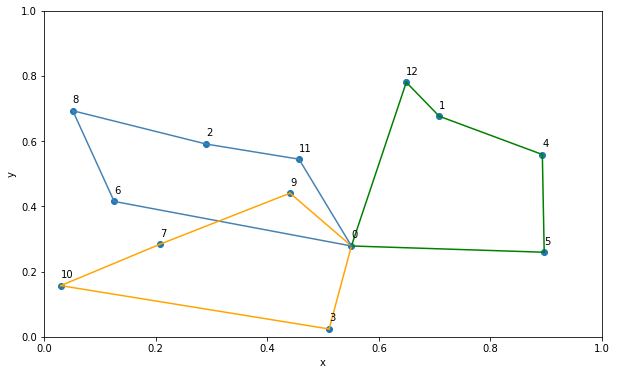

In [9]:
Z, Z_sol= sovle_Bounded_MTSP(c_x, c_y, n_points, n_salesmen, 4, 2)
plt.rcParams['figure.figsize'] = (10,6)
display_points_with_MTSP(points, Z)

Comparison graph of three problems

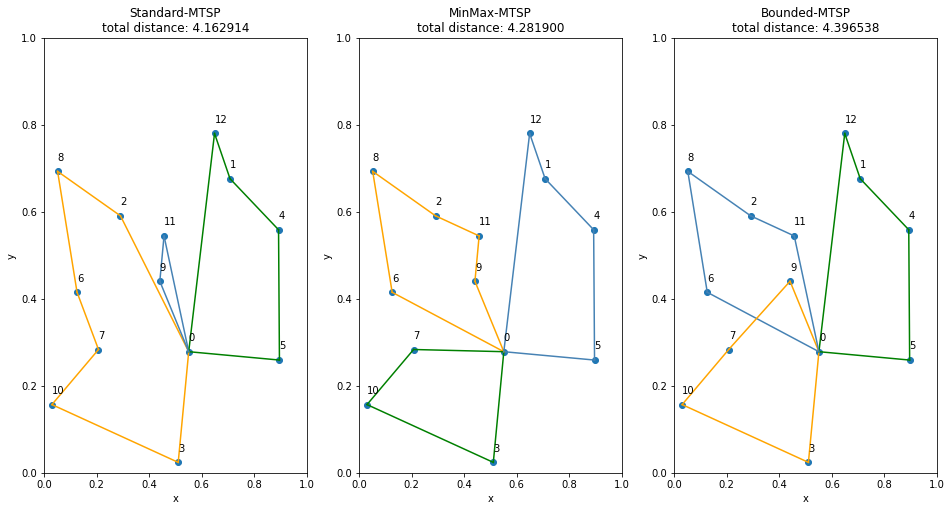

In [10]:
plt.rcParams['figure.figsize'] = (16,8)
plt.subplot(1, 3, 1)
display_points_with_MTSP(points, X)
_ = plt.title('Standard-MTSP\ntotal distance: %f'%X_sol)

plt.subplot(1, 3, 2)
display_points_with_Minmax_MTSP(points, Y)
_ = plt.title('MinMax-MTSP\ntotal distance: %f'%total_distance)

plt.subplot(1, 3, 3)
display_points_with_MTSP(points, Z)
_ = plt.title('Bounded-MTSP\ntotal distance: %f'%Z_sol)